In [1]:
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.data as gd
from torch_geometric.utils import from_smiles

import torch
import torch.nn.functional as F
from torch import nn

import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem

# check version
print("torch_geometric\t", torch_geometric.__version__)
print("torch\t", torch.__version__)
print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)
print("rdkit\t", rdkit.__version__)

torch_geometric	 2.3.1
torch	 2.0.1
pandas	 2.1.1
numpy	 1.26.0
rdkit	 2023.03.3


# Data Handling with `torch_geometric`

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

<img src=https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg width=300>

Although the graph has only two edges, we need to define four index tuples to account for both directions of a edge.

In [2]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], 
                  [0], 
                  [1]], dtype=torch.float)

data = gd.Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[3, 1], edge_index=[2, 4])

We will use `torch_geometric.utils.from_smiles` to convert SMILES into `torch_geometric.data.Data` type.

- `data.x`: Node feature matrix with shape [num_nodes, num_node_features]

- `data.edge_index`: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- `data.edge_attr`: Edge feature matrix with shape [num_edges, num_edge_features]

Note that there are two edge indices for each edge, since we are representing a molecule as an undirected graph.

In [3]:
data1 = from_smiles('O1c2c(cc(cc2)-c2cc(OC(C)C)ccc2)C2(N=C(N)N(C)C2=O)CC1(C)C')
data2 = from_smiles('OC(C(NC(=O)C1CC(CCC1)C(NC(=O)C)C(C)C)Cc1ccccc1)CC(C(=O)NCCCC)C')
data3 = from_smiles('S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]C(CC)C)Cc1ccccc1)C')

print(data1)
print()
print(data2)
print()
print(data3)

Data(x=[29, 9], edge_index=[2, 64], edge_attr=[64, 3], smiles='O1c2c(cc(cc2)-c2cc(OC(C)C)ccc2)C2(N=C(N)N(C)C2=O)CC1(C)C')

Data(x=[37, 9], edge_index=[2, 76], edge_attr=[76, 3], smiles='OC(C(NC(=O)C1CC(CCC1)C(NC(=O)C)C(C)C)Cc1ccccc1)CC(C(=O)NCCCC)C')

Data(x=[37, 9], edge_index=[2, 80], edge_attr=[80, 3], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]C(CC)C)Cc1ccccc1)C')


# Batched Graphs

Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension. This composition allows differing number of nodes and edges over examples in one batch:

\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}\end{split}


`batch` is a column vector which maps each node to its respective graph in the batch:

\begin{bmatrix} 0 & \cdots & 0 & 1 & \cdots & n - 2 & n -1 & \cdots & n - 1 \end{bmatrix}

In [4]:
g = gd.Batch.from_data_list([data1, data2, data3])
g

DataBatch(x=[103, 9], edge_index=[2, 220], edge_attr=[220, 3], smiles=[3], batch=[103], ptr=[4])

In [5]:
g.num_graphs

3

In [6]:
g.num_nodes

103

In [7]:
g.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2])

# Graph Convolutional Network

The graph convolutional operator from the “Semi-supervised Classification with Graph Convolutional Networks” paper.

$$
\mathbf{X}^{\prime} = \mathbf{{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops.

In [8]:
class GCN(nn.Module):
    def __init__(self, in_channels, emb_dim=64):
        super().__init__()
        self.conv1 = gnn.GCNConv(in_channels, emb_dim)
        self.conv2 = gnn.GCNConv(emb_dim, emb_dim)
        
    def forward(self, g):
        x, edge_index = g.x.float(), g.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        glob = gnn.global_mean_pool(x, g.batch)
        return x, glob
    
in_channels = g.x.shape[1]
emb_dim = 128

model = GCN(in_channels, emb_dim)
node_features, graph_features = model(g)

print("Shape of node_features\t", node_features.shape)
print("Shape of graph_features\t", graph_features.shape)

Shape of node_features	 torch.Size([103, 128])
Shape of graph_features	 torch.Size([3, 128])


# Feature Extraction using GCN

In [9]:
# Get dataset
url = (
    'https://raw.githubusercontent.com'\
    '/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
)
dataset = pd.read_csv(url)

caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# Transform smiles to tensors using torch_geometric.utils.from_smiles
caffeine_data = from_smiles(caffeine)
data_list = dataset.SMILES.apply(from_smiles).tolist()

In [10]:
_, caffeine_tensor = model(caffeine_data)
_, other_tensor = model(gd.Batch.from_data_list(data_list))


# compute cosine similarity and sort
sims = F.cosine_similarity(caffeine_tensor, other_tensor, dim=1)
idx = torch.argsort(sims.flatten())

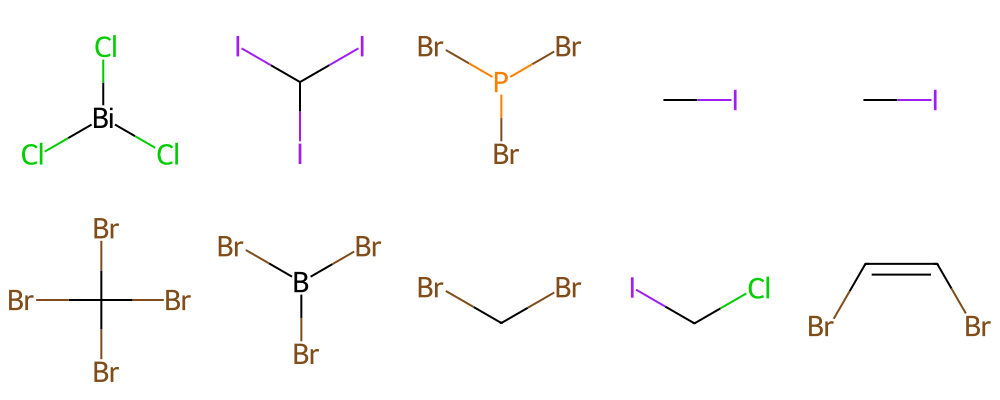

In [11]:
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).to_numpy()
Chem.Draw.MolsToGridImage(molecules[idx[:10]], molsPerRow=5)

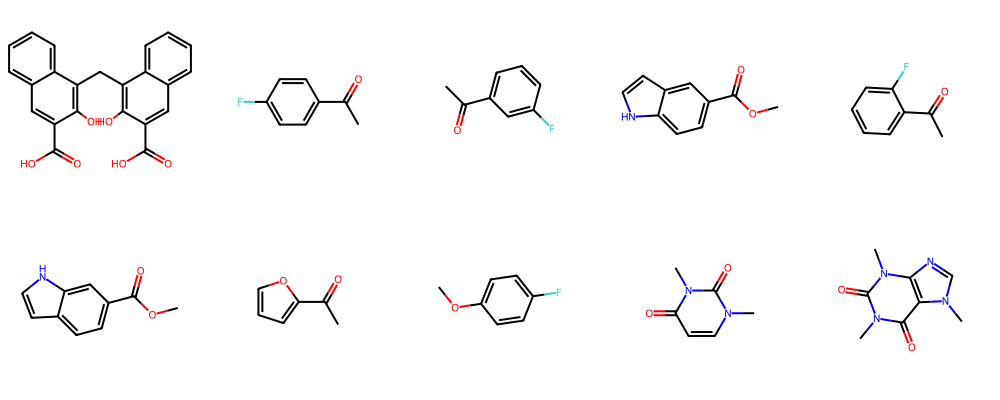

In [12]:
Chem.Draw.MolsToGridImage(molecules[idx[-10:]], molsPerRow=5)

# Edge Case

GCN cannot distinguish Decalin and Bicyclopentyl graphs as shown below, i.e., two graph-level features are the same. This is generally true for standard **message passing graph nueral networks (MPNNs)**. It is well known that standard MPNNs are as expressive as the 1-WL test, but it suffices to know for now that there are more powerful architecture designs to remedy the problem.

- WL test: https://process-mining.tistory.com/170

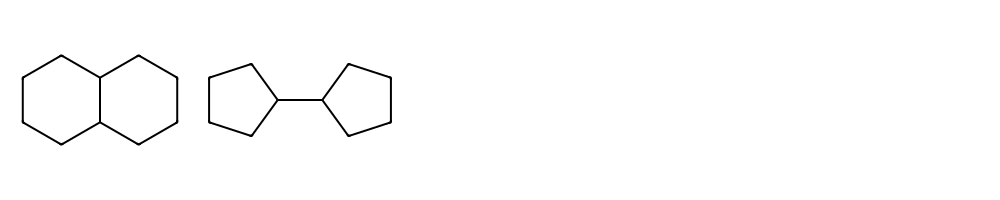

In [13]:
decalin = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
bicyclopentyl  = Chem.MolFromSmiles("C1CCC(C1)C2CCCC2")

Chem.Draw.MolsToGridImage([decalin, bicyclopentyl], molsPerRow=5)

In [14]:
g = gd.Batch.from_data_list([
    from_smiles("C1CCC2CCCCC2C1"), 
    from_smiles("C1CCC(C1)C2CCCC2")
])

_, glob = model(g)

F.cosine_similarity(glob, glob)


tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)

# References

Stanford에서 제공하는 GNN 강좌. 유튜브에서 볼 수 있으며, 실습 파일도 제공한다.

- https://web.stanford.edu/class/cs224w/

딥러닝을 이용한 신약 개발에 특화된 파이썬 라이브러리

- `torchdrug`: https://torchdrug.ai/
- `deepchem`: https://deepchem.io/

# Question


- 각 기호의 의미가 다음과 같다고 하자.

    - $\mathbf{D}$: Degree matrix. `(N, N)` \
        Node degree가 대각선에 위치하고 나머지는 0인 대각행렬이다.
    - $\mathbf{A}$: Adjacency matrix. `(N, N)`
    - $\mathbf{X}$: Node feature matrix. `(N, D)`
    
    이때 아래 수식이 의미하는 바는? 

$$
\mathbf{D}^{-1} \mathbf{A} \mathbf{X} 
$$
    

- 위에서 우리는 GCN을 전혀 훈련하지 않았다. 그런데도 GCN을 이용해 구한 분자 유사도는 꽤나 정확한 듯하다. 그 이유는 무엇일까?
